In [36]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import csv

Text(0.5, 1.0, 'Random Classification Data with 2 classes')

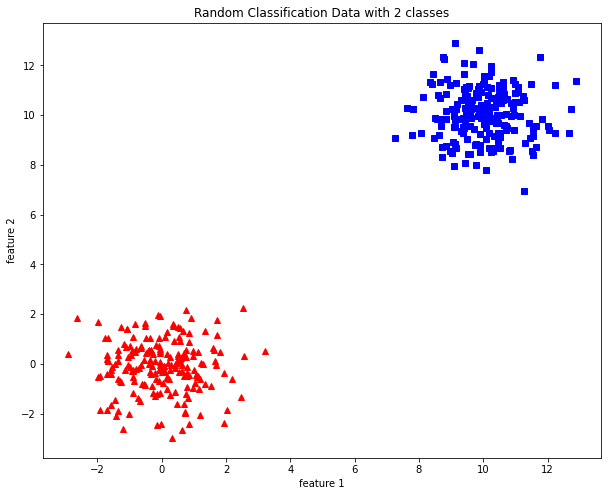

In [37]:
#Perceptron Classifier Construction

#Generate Dataset
N = 400
cov = [[1, 0], [0, 1]]

mean = [0,0]
x1 = np.random.multivariate_normal(mean, cov, N)
y1 = np.ones(N)*-1  #class label -1

mean = [10,10]
x2 = np.random.multivariate_normal(mean, cov, N)
y2 = np.ones(N)  #class label 1

training_set = np.append(x1[:200],x2[:200],axis=0)
training_label = np.append(y1[:200],y2[:200])

test_set = np.append(x1[200:],x2[200:], axis=0)
test_label = np.append(y1[200:],y2[200:])

training_pocket = np.column_stack((training_set, training_label))
training_pocket = np.take(training_pocket,np.random.permutation(training_pocket.shape[0]),axis=0,out=training_pocket) 

test_pocket = np.column_stack((test_set, test_label))

x_pocket = training_pocket[:,:-1]
y_pocket = training_pocket[:,-1]

fig = plt.figure(figsize=(10,8))
plt.plot(x_pocket[:, 0][y_pocket == -1], x_pocket[:, 1][y_pocket == -1], 'r^')
plt.plot(x_pocket[:, 0][y_pocket == 1], x_pocket[:, 1][y_pocket == 1], 'bs')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title('Random Classification Data with 2 classes')


In [38]:
def classifier (data,maxiterent):
    
    x = data[:,:-1]
    y = data[:,-1]
    N,d = x.shape # N - number of samples, d - number of features
    ind = np.arange(N) #index for random sampling
    
   
    nv = 0 # Number of consecutive iterations for which weight vector v correctly classified the examples
    nw = 0 # Number of consecutive iterations for which weight vector w correctly classified the examples
    vi = np.zeros((d+1,1)) # Current weight vector for the perceptron
    #wi = 0
    wi = np.zeros((d+1,1)) # Output Weight Vector
    iterent = 0
    x = np.insert(x,0, 1, axis=1)

    for i in (range(maxiterent)):
       # for idx in range(N):
            rand_ind = np.random.choice(ind,1, replace=True)
            xi = x[rand_ind]
            yi = y[rand_ind]

            yhat = np.where(np.dot(xi,vi)>= 0,1,-1)

                
            if yhat*yi > 0:
                nv = nv+1
            else:
                if nv>nw:
                    wi = vi
                    nw = nv
                vi += (yi-yhat)*xi.T
                
                nv = 0
            iterent = iterent+1
        
    return wi

In [39]:
def predict(data,w):
    prediction = []
    sum_error = 0
    for row in data:
        activation = w[0]
        for i in range(len(row)-1):
            activation += w[i +1]*row[i]
        pred = 1 if activation >= 0 else -1
        error = row[-1]-pred
        sum_error += error**2
        prediction.append(pred)
      #  print('>predicted=%d, expected=%.3f, error=%.3f' % (pred, row[-1], sum_error))
    return np.array(prediction), sum_error

In [40]:
w = classifier(training_pocket,10000)
print(w)
Prediction_Pocket, Sum_Error = predict(test_pocket,w)
Expected_Pocket = test_pocket[:,-1].astype(int)

[[-32.        ]
 [  2.55755179]
 [ 10.08706988]]


In [41]:
Sum_Error

764.0

In [72]:
def adabtrain(data, k):

    N,d = data.shape # N - number of samples, d - number of features
    K = np.arange(10, k, 10) # Learners
    w1 = np.ones(N)*1/N
    ind = np.arange(len(data))
    Hx = np.zeros((N,0),int)
    confmat = np.zeros((2,2))
    plot_accuracy = []
    plot_k =[]
    
    y = data[:,-1] 
    alpha = []
    H = []
    for i in tqdm(range(k)):
        #random sample with replacement
        
        start = time.time()
        
        train_ind = np.random.choice(ind,N,p = w1, replace=True)
       # w = w1[train_ind]
        s1 = data[train_ind]
        x1 = s1[:,:-1]
        y1 = s1[:,-1]
        
        h = classifier(s1,10000)
        
        hx = predict(data,h) #y predict
        delta = np.where( y != hx[0], 1, 0)
        err = sum(delta*w1)
        a = 0.5*np.log((1-err)/err)
        w1 = w1*np.exp(-1*a*y*hx[0])
        z = sum(w1)
        w1 = w1/z
        end = time.time()
        
      #  print(end-start)
        
        alpha.append(a)
        H.append(h)
        Hx = np.concatenate([Hx, hx[0][:,None]], axis=1)
        
        if (i+1)%10 == 0:
            TP = np.count_nonzero((y == -1) & (hx[0] == -1))
            TN = np.count_nonzero((y == 1) & (hx[0] == 1))
            FN = np.count_nonzero((y == 1) & (hx[0] == -1))
            FP = np.count_nonzero((y == -1) & (hx[0] == 1))

            confmat[0][0]= TP
            confmat[0][1]= FP
            confmat[1][0]= FN
            confmat[1][1]= TN
            
            accuracy=((confmat[0][0]+confmat[1][1])/np.sum(confmat)*100)
            plot_accuracy.append(accuracy)
            plot_k.append(i+1)
    
    plt.plot(plot_k,plot_accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('K Learner')
    plt.title('Accuracy vs K Learner Training Data')
    plt.show
    return alpha, H,Hx

In [73]:
def adabpredict(data,k,alpha, H):
    confmat = np.zeros((2,2))
    plot_accuracy = []
    plot_k =[]
    yexp = data[:,-1]
    y = []
    for i in range(k):
        ypred_k = predict(data,H[i])[0]
        y.append(int(np.sign(sum(alpha[i]*ypred_k))))
        
        if (i+1)%10 == 0:
            TP = np.count_nonzero((yexp == -1) & (ypred_k == -1))
            TN = np.count_nonzero((yexp == 1) & (ypred_k == 1))
            FN = np.count_nonzero((yexp == 1) & (ypred_k == -1))
            FP = np.count_nonzero((yexp == -1) & (ypred_k == 1))

            confmat[0][0]= TP
            confmat[0][1]= FP
            confmat[1][0]= FN
            confmat[1][1]= TN
            
            accuracy=((confmat[0][0]+confmat[1][1])/np.sum(confmat)*100)
            plot_accuracy.append(accuracy)
            plot_k.append(i+1)
    
    plt.plot(plot_k,plot_accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('K Learner')
    plt.title('Accuracy vs K Learner of Test Data')
    plt.show
        
    return y

In [74]:
#Banana Dataset

filedata = 'C:/Users/KEC/OneDrive - University of the Philippines/MSEE/CS280/PA3/CS280_PA3_2021-22_Boosting_vs_SVM/CS280_PA3_2021-22_Boosting_vs_SVM/banana_data.csv'

with open(filedata, 'r') as file:
    data = np.array(list(csv.reader(file, delimiter=',',quoting=csv.QUOTE_NONNUMERIC)))

data = np.take(data,np.random.permutation(data.shape[0]),axis=0,out=data)  #shuffle data
data = np.insert(data[:,[-2,-1]],len(data[:,[-2,-1]][0]),data[:,0],axis=1)
banana_training = data[:400]
banana_test = data[400:]

banana_train_label = banana_training[:,-1]
banana_train_data = banana_training[:,[0,1]]

100%|██████████| 1000/1000 [26:18<00:00,  1.58s/it]


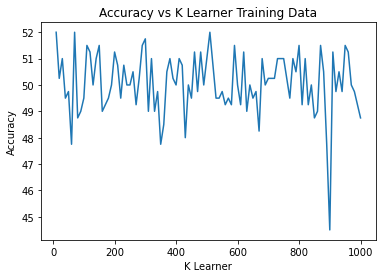

In [75]:
alpha,H,Hx = adabtrain(banana_training,1000)

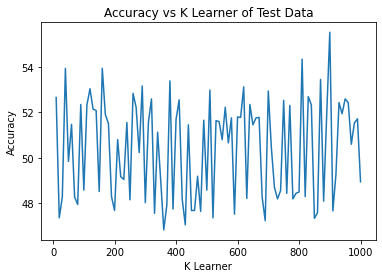

In [76]:
y_pred = adabpredict(banana_test,1000,alpha,H)

In [69]:
#Splice Dataset

filedata = 'C:/Users/KEC/OneDrive - University of the Philippines/MSEE/CS280/PA3/CS280_PA3_2021-22_Boosting_vs_SVM/CS280_PA3_2021-22_Boosting_vs_SVM/splice_data.csv'

with open(filedata, 'r') as file:
    data = np.array(list(csv.reader(file, delimiter=',',quoting=csv.QUOTE_NONNUMERIC)))

data = np.take(data,np.random.permutation(data.shape[0]),axis=0,out=data) #shuffle data
data = np.insert(data[:,1:],len(data[:,1:][0]),data[:,0],axis=1)
splice_training = data[:1000]
splice_test = data[1000:]

splice_train_label = splice_training[:,-1]
splice_train_data = splice_training[:,:-1]

100%|██████████| 1000/1000 [58:24<00:00,  3.50s/it] 


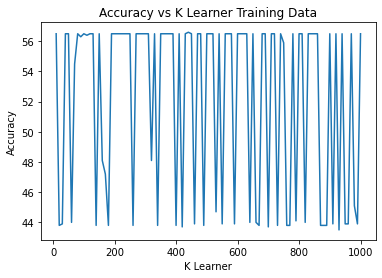

In [78]:
alpha,H,Hx = adabtrain(splice_training,1000)

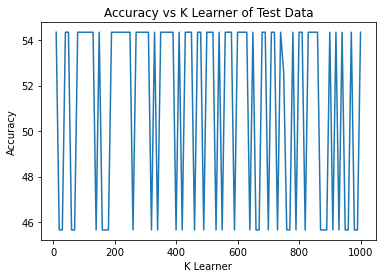

In [79]:
y_pred = adabpredict(splice_test,1000,alpha,H)

In [83]:
from libsvm.svmutil import *

banana = 'C:/Users/KEC/OneDrive - University of the Philippines/MSEE/CS280/PA3/CS280_PA3_2021-22_Boosting_vs_SVM/CS280_PA3_2021-22_Boosting_vs_SVM/banana_data.libsvm'

y, x = svm_read_problem(banana)
#isKernel=True must be set for precomputer kernel
#prob  = svm_problem(y[:400], x[:400], isKernel=True)
#param = svm_parameter('-t 4 -c 4 -b 1')
#m = svm_train(y[:400], x[:400] ,[ '-t 4 -c 4 -b 1'])
#m = svm_train(y[:400], x[:400], '-c 4')
#p_label, p_acc, p_val = svm_predict(y[400:], x[400:], m)

prob = svm_problem(y[:400], x[:400])
param = svm_parameter('-s 0 -t 2 -c 5 -h 0')
#m = svm_train(y[:400], x[:400], '-c 5')
#m = svm_train(prob, '-t 2 -c 5')
m = svm_train(prob, param)
CV_ACC = svm_train(y[:400], x[:400], '-v 3')
p_label, p_acc, p_val = svm_predict(y[400:], x[400:], m)



Cross Validation Accuracy = 96.5%
Accuracy = 55.7551% (2732/4900) (classification)


In [84]:
#%%
splice_data = 'C:/Users/KEC/OneDrive - University of the Philippines/MSEE/CS280/PA3/CS280_PA3_2021-22_Boosting_vs_SVM/CS280_PA3_2021-22_Boosting_vs_SVM/splice_data.libsvm'


y, x = svm_read_problem(splice_data)

prob = svm_problem(y[:1000], x[:1000])
param = svm_parameter('-s 1 -t 1 -c 5 -h 0')
#m = svm_train(y[:400], x[:400], '-c 5')
#m = svm_train(prob, '-t 2 -c 5')
m = svm_train(prob, param)
CV_ACC = svm_train(y[:1000], x[:1000], '-v 3')
Form a training dataset of 400 points and test set
of 4900 points from banana dataset. Run the Support
Vector Machine Classifier on these sets. Find the kernel
and kernel parameters to obtain the best performance.
Repeat for the splice dataset with 1000 training points
and 2175 test points. Compare the performance of SVM
with Boosted Perceptrons in terms of test accuracy,
training and test speeds.
p_label, p_acc, p_val = svm_predict(y[1000:], x[1000:], m)

Cross Validation Accuracy = 86.5%
Accuracy = 84.2793% (1678/1991) (classification)
